![Demosaicking](https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/main/Sesiones/Sesion2/Images/poster_sesion2.png)

# **Hands-on Sesión 2.1: Image Demosaicking** 🏞️

Demosaicing (o de-mosaicing, demosaicking), también conocido como reconstrucción de color, es un algoritmo de procesamiento de imágenes digitales que se utiliza para reconstruir una imagen a todo color a partir de muestras de color incompletas generadas por un sensor de imagen superpuesto con una matriz de filtros de color (CFA), como un filtro Bayer. También se conoce como interpolación CFA o debayering.

La mayoría de las cámaras digitales modernas adquieren imágenes utilizando un único sensor de imagen superpuesto con un CFA, por lo que la demostración es parte del proceso de procesamiento necesario para representar estas imágenes en un formato visible.

Muchas cámaras digitales modernas pueden guardar imágenes en formato RAW (sin formato), lo que permite al usuario realizar una demostración mediante software, en lugar de utilizar el firmware integrado de la cámara.

# Objetivo:
El objetivo de un algoritmo de demosaicking es reconstruir una imagen a todo color (es decir, un conjunto completo de tripletas de color) a partir de los canales de color espacialmente submuestreados emitidos por el CFA. El algoritmo debe tener las siguientes características:



*   Evitar la introducción de artefactos de color falso, como alias cromáticos, cremalleras (cambios bruscos y antinaturales de intensidad en varios píxeles vecinos) y franjas moradas
*   Máxima preservación de la resolución de la imagen
*   Baja complejidad computacional para un procesamiento rápido o una implementación eficiente del hardware en la cámara
*   Facilidad de análisis para una reducción precisa del ruido


![Demosaicking](https://drive.google.com/uc?id=1j3J5P2GZV_tHFzL7xJ8bNh9KnmL8Q1sX)




# Imágenes RAW

Existen diferentes formatos de imágenes tipo .RAW:

![RAW Image Formats](https://drive.google.com/uc?id=1Pi0NO8lyRgqadX6JTvALG-cx-JA471gH)



## **Contenido**

[**1. Llenando vacios**](#tema1)

[**2. Probemos con una imagen**](#tema2)

[**3. Hagamos demosaicking**](#tema3)

[**4. Correcciones de color**](#tema4)

librerias necesarias:

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv

descarguemos lo necesario

In [127]:
!wget https://github.com/semilleroCV/Hands-on-Computer-Vision/raw/main/Sesiones/Sesion2/Imagenes/raw_GOPRO1.dng

--2024-04-15 19:59:04--  https://github.com/semilleroCV/Hands-on-Computer-Vision/raw/main/Sesiones/Sesion2/Imagenes/raw_GOPRO1.dng
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/main/Sesiones/Sesion2/Imagenes/raw_GOPRO1.dng [following]
--2024-04-15 19:59:05--  https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/main/Sesiones/Sesion2/Imagenes/raw_GOPRO1.dng
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977972 (14M) [application/octet-stream]
Saving to: ‘raw_GOPRO1.dng.2’

raw_GOPRO1.dng.2    100%[===================>]  14.28M  --.-KB/s 

## <font color='#4C5FDA'>**1. Llenando vacios**</font> <a name="tema1">


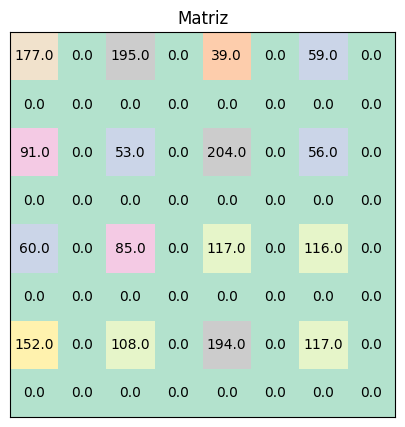

In [128]:
my_array = np.zeros((8, 8))
my_array[::2,::2] = np.random.randint(30, 255, (4, 4))

def plot_tensor_resul(tensor_a,  label_resul=""):
    plt.figure(figsize=(10, 5))
    plt.title("Matriz")
    plt.imshow(tensor_a, cmap="Pastel2")
    plt.xticks([])
    plt.yticks([])
    for (i, j), z in np.ndenumerate(tensor_a):
        plt.text(j, i, '{}'.format(z), ha='center', va='center')

a_plus_b = my_array

plot_tensor_resul(my_array)

## <font color="EB9A54"> **Reto No.1:** </font> Rellena los valores que son 0 en la matriz haciendo interpolacion

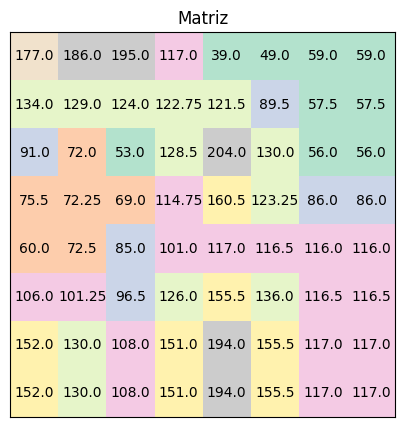

<Figure size 1200x500 with 0 Axes>

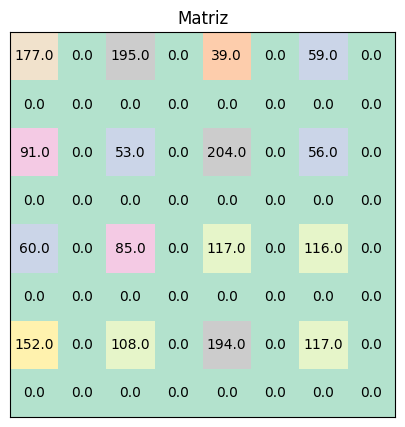

In [129]:
# Reto No.1:  Rellena los valores que son 0 en la matriz haciendo interpolacion
# Aqui tu codigo:
# Reto No.1:  Rellena los valores que son 0 en la matriz haciendo interpolacion
# Aqui tu codigo:
def fill_zeros_with_interpolation(matrix):
    # Crear una copia para modificar los valores
    interpolated_matrix = np.copy(matrix)
    rows, cols = matrix.shape

    for i in range(rows):
        for j in range(cols):
            if matrix[i, j] == 0:
                # Determinar los límites de la submatriz 1.1
                r_min = max(0, i-1) # 0
                r_max = min(rows, i+2) # 3
                c_min = max(0, j-1) # 0
                c_max = min(cols, j+2) # 3

                # Extraer submatriz y calcular la media de los valores no cero
                sub_matrix = matrix[r_min:r_max, c_min:c_max]
                non_zero_values = sub_matrix[sub_matrix != 0]
                if non_zero_values.size > 0:
                    mean_value = np.mean(non_zero_values)
                    interpolated_matrix[i, j] = mean_value
                else:
                    # En caso de que todos los valores cercanos también sean cero
                    interpolated_matrix[i, j] = 0

    return interpolated_matrix

my_array_inte = plot_tensor_resul(fill_zeros_with_interpolation(my_array))

plt.figure(figsize=(12, 5))
plot_tensor_resul(my_array, "Matriz original")
plt.show()

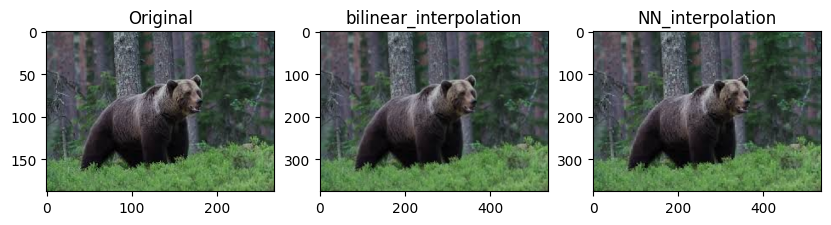

In [130]:
from PIL import Image
import requests
# Rta No.1:
# source:https://programmerclick.com/article/31811403992/
def BiLinear_interpolation(img,dstH,dstW):
    #dstH = img.shape[0] * 2
    #dstW = img.shape[1] * 2
    scrH,scrW,_=img.shape
    img=np.pad(img,((0,1),(0,1),(0,0)),'constant')
    retimg=np.zeros((dstH,dstW,3),dtype=np.uint8)
    for i in range(dstH):
        for j in range(dstW):
            scrx=(i+1)*(scrH/dstH)-1
            scry=(j+1)*(scrW/dstW)-1
            x=math.floor(scrx)
            y=math.floor(scry)
            u=scrx-x
            v=scry-y
            retimg[i,j]=(1-u)*(1-v)*img[x,y]+u*(1-v)*img[x+1,y]+(1-u)*v*img[x,y+1]+u*v*img[x+1,y+1]
    return retimg

def NN_interpolation(img,dstH,dstW):
    #agrandado de imagen
    scrH,scrW,_=img.shape
    retimg=np.zeros((dstH,dstW,3),dtype=np.uint8)
    for i in range(dstH):
        for j in range(dstW):
            scrx=round((i+1)*(scrH/dstH))
            scry=round((j+1)*(scrW/dstW))
            retimg[i,j]=img[scrx-1,scry-1]
    return retimg

url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcResE9MolPTJBjETxiolyXNAFZHJXuuXduiCpvlMkyF-g&s"
img = np.array(Image.open(requests.get(url, stream=True).raw))

bilinear_img = BiLinear_interpolation(img, img.shape[0] * 2, img.shape[1] * 2)
NN_img = NN_interpolation(img, img.shape[0] * 2, img.shape[1] * 2)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(bilinear_img)
plt.title('bilinear_interpolation')

plt.subplot(1, 3, 3)
plt.imshow(NN_img)
plt.title('NN_interpolation')

plt.show()

## <font color='#4C5FDA'>**2. Probemos con una imagen**</font> <a name="tema2">


Vamos a usar una libreria especial para leer imágenes RAW


In [131]:
!pip install -q rawpy

Importemos los paquetes necesarios para realizar el procesamiento

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy
from scipy.ndimage import filters

Leamos y mostremos una de las imágenes RAW disponibles en nuestra carpeta

Leyendo imagen .RAW ...
Tamaño de la imagen: (3000, 4000)


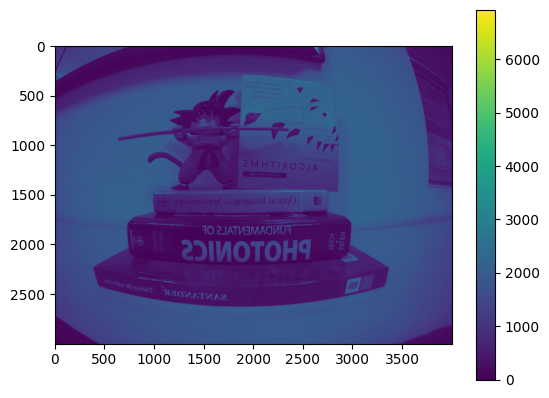

In [133]:
with rawpy.imread("raw_GOPRO1.dng") as raw:
    print('Leyendo imagen .RAW ...')
    image = raw.raw_image.copy()


print(f'Tamaño de la imagen: {image.shape}')
plt.imshow(image)
plt.colorbar()
plt.show()

## <font color= "52F17F"> **Hazlo tu mismo Nº1:**  </font>  Haz plot de difernetes zonas de la imagen

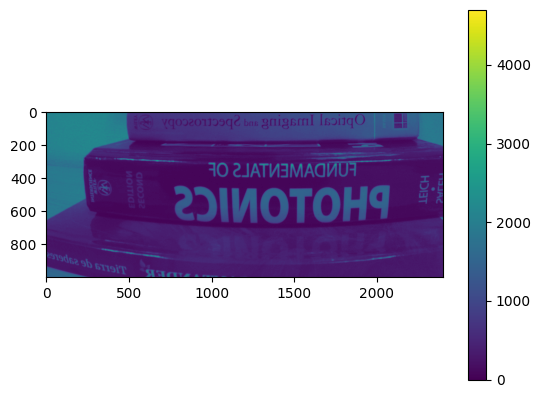

In [134]:
# Enfocandonos en una región particular
plt.imshow(image[1500:2500, 500:2900]) # cambia esto!
plt.colorbar()
plt.show()

Hagamos Zoom para ver el patrón Bayer

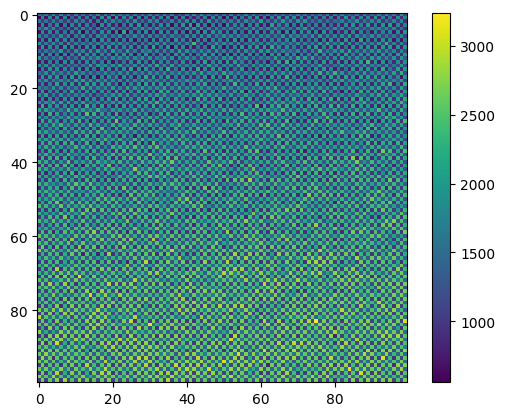

In [135]:
plt.imshow(image[310:410, 1405:1505]) # cuales serian los valoes para enfocar el logo de internet explorer?

plt.colorbar()
plt.show()

## <font color='#4C5FDA'>**3. Hagamos demosaicking**</font> <a name="tema3">

Comenzaremos separando el canal único en tres canales de colores diferentes: rojo, verde y azul (RGB).

## <font color="EB9A54"> **Reto No.2:** </font> Separemos la matriz en 3 matrices, una con la informacion de cada canal

![link text](https://drive.google.com/uc?id=1Y9eIFwS0nMxZ80ngaqTHXNPXTJ8Nx96C)

In [153]:
RED = 0
GREEN = 1
BLUE = 2
def get_cfa_channel(i, j):
    # CR2 CFA Pattern: [Red   , Green] <-- even rows: 0, 2, 4, ...
    #                  [Green , Blue]  <-- odd  rows: 1, 3, 5, ...
    if i % 2 == 0:  # Filas pares
        if j % 2 == 0:  # Columnas pares
            return RED
        else:
            return GREEN
    else:  # Filas impares
        if j % 2 == 0:  # Columnas pares
            return GREEN
        else:
            return BLUE



In [154]:
get_cfa_channel(1,1)

2

In [155]:
def get_cfa_mask(shape):
    mask = np.zeros(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            if (i % 2 == 0) and (j % 2 == 0):
                mask[i, j] = RED
            elif (i % 2 == 0) and (j % 2 == 1):
                mask[i, j] = GREEN
            elif (i % 2 == 1) and (j % 2 == 0):
                mask[i, j] = GREEN
            elif (i % 2 == 1) and (j % 2 == 1):
                mask[i, j] = BLUE
    return mask
    # return mask

In [156]:
cfa_mask = get_cfa_mask(image.shape)

In [157]:
cfa_mask.shape

(3000, 4000)

In [158]:
cfa_mask.dtype

dtype('float64')

In [159]:
print(cfa_mask) # que significa esa matriz?

[[0. 1. 0. ... 1. 0. 1.]
 [1. 2. 1. ... 2. 1. 2.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [1. 2. 1. ... 2. 1. 2.]
 [0. 1. 0. ... 1. 0. 1.]
 [1. 2. 1. ... 2. 1. 2.]]


In [160]:
print('Comenzando proceso de Demosaicking:')
print('Extrayendo filtros respecto a su posición...')
r_mask = (cfa_mask == RED)
g_mask = (cfa_mask == GREEN)
b_mask = (cfa_mask == BLUE)

print('Separando los diferentes canales de color...')
r = image * r_mask
g = image * g_mask
b = image * b_mask

Comenzando proceso de Demosaicking:
Extrayendo filtros respecto a su posición...
Separando los diferentes canales de color...


hagamos el plot!

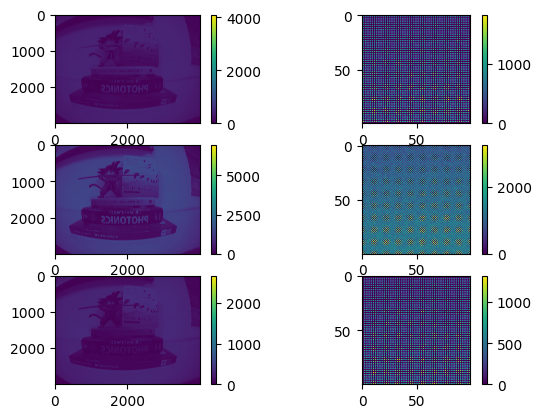

In [161]:
plt.subplot(3,2,1)
plt.imshow(r)
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(r[310:410, 1405:1505])
plt.colorbar()
#plt.show()

plt.subplot(3,2,3)
plt.imshow(g)
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(g[310:410, 1405:1505])
plt.colorbar()
#plt.show()

plt.subplot(3,2,5)
plt.imshow(b)
plt.colorbar()
plt.subplot(3,2,6)
plt.imshow(b[310:410, 1405:1505])
plt.colorbar()
#plt.show()

## <font color="EB9A54"> **Reto No.3:** </font> Rellenemos los huecos, ahora en toda la imagen

https://www.researchgate.net/publication/337699237/figure/fig1/AS:831856467509248@1575341445163/Standard-approach-to-demosaicing-CFA-20-images-Image-from-38.ppm

proceso demosaicing

<ipython-input-162-6e58a98660f4>:13: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  r =  filters.convolve(r, RB_KERNEL, mode='nearest')
<ipython-input-162-6e58a98660f4>:14: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  g = filters.convolve(g, RB_KERNEL, mode='nearest')
<ipython-input-162-6e58a98660f4>:15: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  b = filters.convolve(b, RB_KERNEL, mode='nearest')


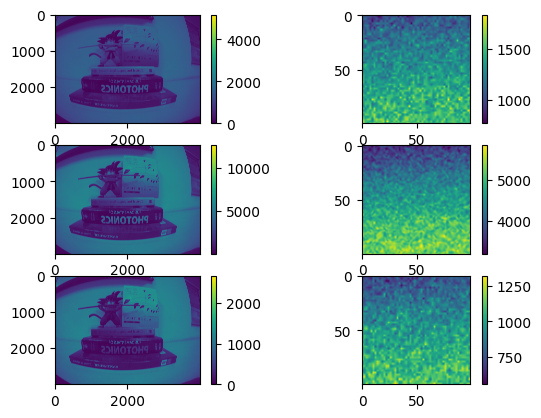

In [162]:
#Filtro lineal para el canal verde
G_KERNEL = np.array([[0, 1, 0],
                     [1, 4, 1],
                     [0, 1, 0]]) / 4.0


#Filtro lineal para los canales azul y rojo (Note la diferencia)
RB_KERNEL = np.array([[1, 2, 1],
                      [2, 4, 2],
                      [1, 2, 1]]) / 4.0

#
r =  filters.convolve(r, RB_KERNEL, mode='nearest')
g = filters.convolve(g, RB_KERNEL, mode='nearest')
b = filters.convolve(b, RB_KERNEL, mode='nearest')

plt.subplot(3,2,1)
plt.imshow(r)
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(r[310:410, 1405:1505])
plt.colorbar()

plt.subplot(3,2,3)
plt.imshow(g)
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(g[310:410, 1405:1505])
plt.colorbar()

plt.subplot(3,2,5)
plt.imshow(b)
plt.colorbar()
plt.subplot(3,2,6)
plt.imshow(b[310:410, 1405:1505])
plt.colorbar()

## <font color="EB9A54"> **Reto No.4:** </font> Agrupa las matrices

Agrupando canales para generar imagen RGB ...


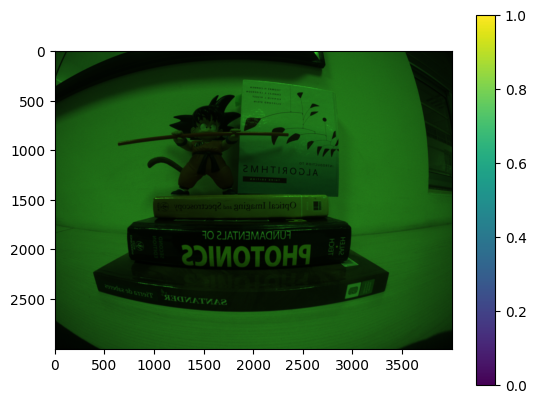

In [184]:
print('Agrupando canales para generar imagen RGB ...')

rgb = np.dstack((r, g, b))


plt.imshow(rgb / rgb.max()) # Normalización
plt.colorbar()
plt.show()

## <font color='#4C5FDA'>**4. Correcciones de color**</font> <a name="tema4">

Comenzaremos separando el canal único en tres canales de colores diferentes: rojo, verde y azul (RGB).


Ajustando el nivel de negro ...
Balanceando blancos ...


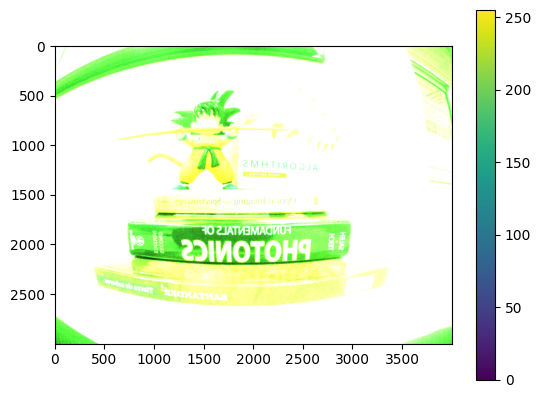

In [185]:
print('Ajustando el nivel de negro ...')
# resta el minimo valor de cada canal a cada canal
rgb -= np.array([np.min(rgb[:,:,0]), np.min(rgb[:,:,1]), np.min(rgb[:,:,2])])

print('Balanceando blancos ...')
###

plt.imshow(rgb)
plt.colorbar()
plt.show()

Nuevamente, este es un enfoque muy básico, ya que no utilizamos ninguna de las estadísticas del fabricante de la cámara ni la sensibilidad configurada con la que se capturó la imagen.

Terminaremos con una corrección gamma (pronto la veremos) para enriquecer los colores.

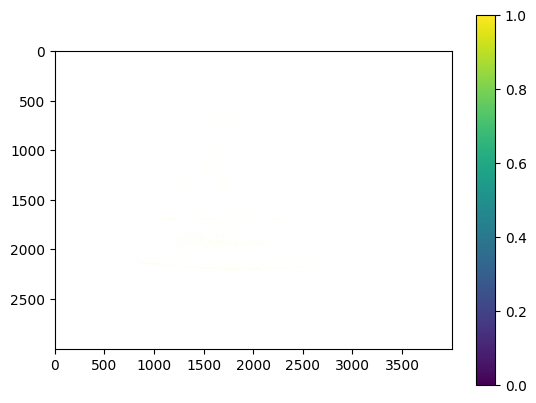

In [186]:
GAMMA = 0.2

# eleva la imagen a el valor gamma
rgb = rgb**GAMMA

plt.imshow(rgb)
plt.colorbar()
plt.show()

Carguemos la imagen .RAW nuevamente y ejecutemos un método avanzado (por defecto en el paquete `rawpy`).
¿Puedes notar la diferencia?

In [ ]:
# Comparando contra la imagen original
with rawpy.imread('raw.CR2') as raw:
    print('Reading image raw data...')
    rgb2 = raw.postprocess(use_camera_wb=True)

plt.imshow(rgb2)

In [ ]:
print(rgb2.dtype)

uint8


como hacen eso?, explora tu mismo el codigo en c++ !
[link al codigo](https://github.com/LibRaw/LibRaw/blob/master/src/demosaic/misc_demosaic.cpp#L127)

![ASdasd](https://i.imgur.com/lmFdwBE.png)